
## Random forest

Leo Breiman found a use for bootstrap not only in statistics, but also in machine learning. He, together with Adele Cutler, improved the random forest algorithm proposed by [Ho] (http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf), adding to the original version the construction of uncorrelated trees on based on CART, combined with the method of random subspaces and bagging. 

Decision trees are a good family of basic classifiers for bagging because they are quite complex and can achieve zero error on any sample. The random subspace method allows reducing the correlation between trees and avoiding overfitting. Basic algorithms are trained on various subsets of the feature description, which are also randomly selected.

An ensemble of models using the random subspace method can be built using the following algorithm:
1. Let the number of objects for training be $\large N$, and the number of features $\large D$.
2. Choose $\large L$ as the number of distinct models in the ensemble.
3. For each individual $\large l$ model, select $\large dl (dl < D)$ as the number of features for $\large l$ . Usually only one $\large dl$ value is used for all models.
4. For each individual $\large l$ model, create a training sample by selecting $\large dl$ features from $\large D$ with replacement and train the model.

Now, to apply the ensemble model to a new object, combine the results of the individual $\large L$ models by majority vote or by combining the posterior probabilities.



### Algorithm

The algorithm for constructing a random forest consisting of $\large N$ trees is as follows:
* For each $\large n = 1, \dots, N$:
     * Generate $\large X_n$ selection using bootstrap.
     * Construct $\large b_n$ decision tree from $\large X_n$ sample:
         — according to a given criterion, we choose the best feature, make a split in the tree according to it, and so on until the selection is exhausted
         — the tree is built until there are no more than $\large n_\text{min}$ objects in each sheet or until we reach a certain height of the tree
         — at each partition, $\large m$ random features are first selected from $\large n$ initial features,
         and the optimal split of the sample is sought only among them.
         
The final classifier $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, in simple words - for the cassification problem, we choose the solution by majority voting, and in the regression problem - average.

It is recommended to take $\large m = \sqrt{n}$ in classification problems, and $\large m = \frac{n}{3}$ in regression problems, where $\large n$ is the number of features. It is also recommended in classification problems to build each tree until there is one object in each leaf, and in regression problems — until there are five objects in each leaf.

Thus, a random forest is bagging over decision trees, in the course of which, for each partition, features are selected from some random subset of features.

### Comparison with decision tree and bagging

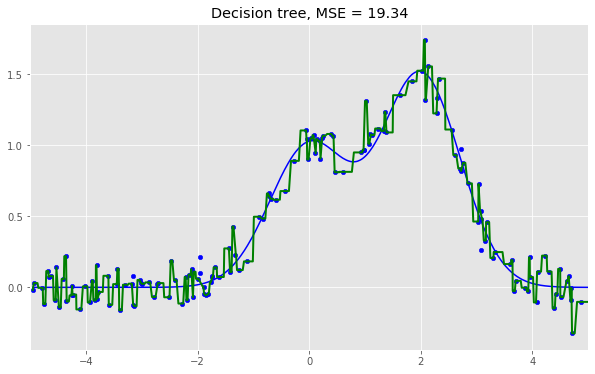

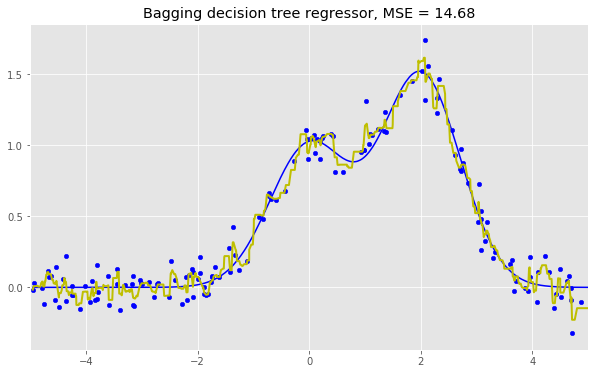

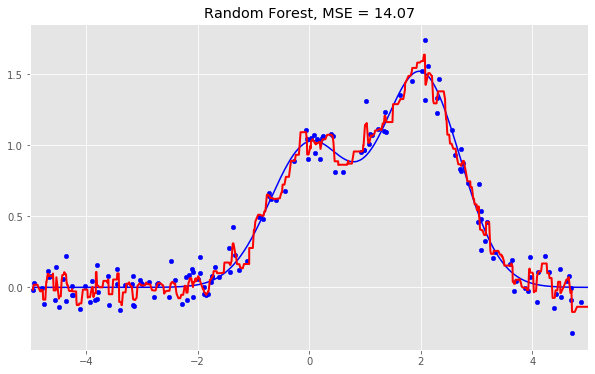

In [2]:
from __future__ import division, print_function

import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 12
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

np.random.seed(42)

n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Bagging decision tree regressor, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random Forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

As we can see from the graphs and MSE error values, a random forest of 10 trees gives a better result than a single tree or bagging of 10 decision trees. The main difference between random forest and decision tree bagging is that in a random forest, a random subset of features is selected from a random number, and the best feature to split a node is determined from the subset of features, unlike bagging, where all features are considered for splitting at a node.

You can also see the advantage of random forest and bagging in classification problems.


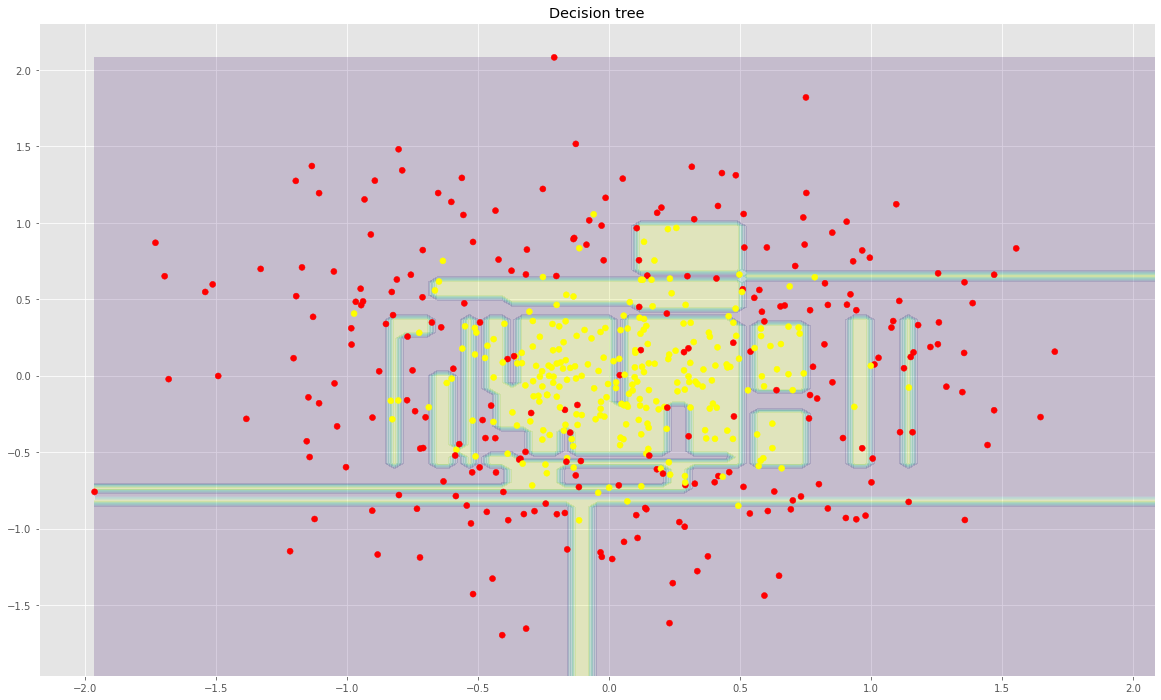

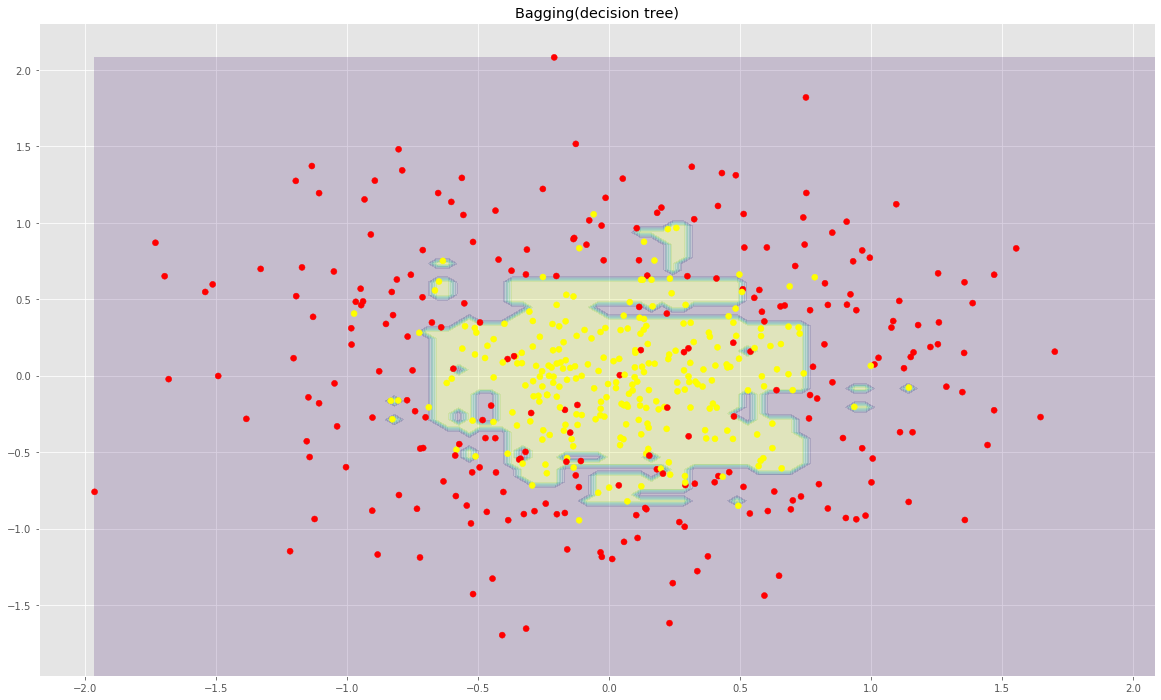

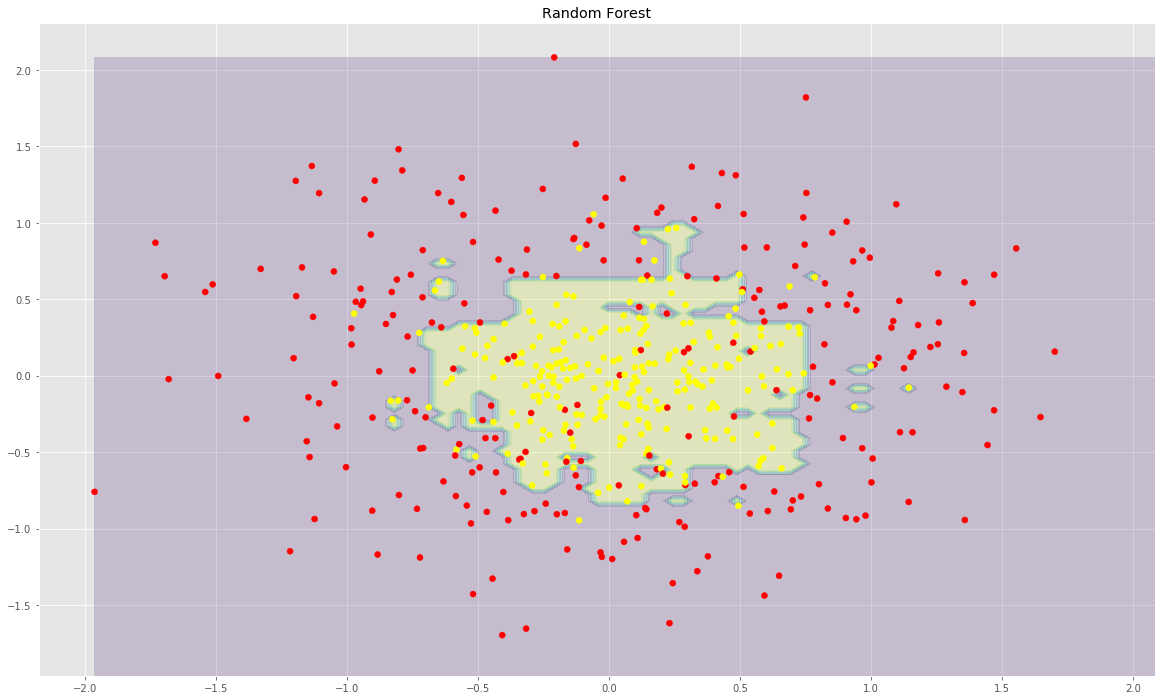

In [3]:
plt.rcParams['figure.figsize'] = 20, 12
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Decision tree")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Bagging(decision tree)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Random Forest")
plt.show()

In the figures above, it can be seen that the separating boundary of the decision tree is very “torn” and has many sharp corners, which indicates overfitting and poor generalizing ability. While bagging and random forest have a fairly smoothed border and there are practically no signs of overfitting.

Let's now try to figure out the parameters by selecting which we can increase the proportion of correct answers.

### Options

The random forest method is implemented in the machine learning library [scikit-learn](http://scikit-learn.org/stable/) by two classes RandomForestClassifier and RandomForestRegressor.

Full list of random forest parameters for the regression problem:

```class sklearn.ensemble.RandomForestRegressor(
     n_estimators - the number of trees in the "forest" (default - 10)
     criterion - a function that measures the quality of splitting a tree branch (by default - "mse" , you can also choose "mae")
     max_features - the number of features by which the partition is searched. You can specify a specific number or percentage of features, or choose from the available values: "auto" (all features), "sqrt", "log2". The default is "auto".
     max_depth - the maximum depth of the tree (the depth is not limited by default)
     min_samples_split - The minimum number of features required to split an internal node. Can be set as a number or percentage of the total number of objects (default is 2)
     min_samples_leaf - The minimum number of features in a leaf. Can be set as a number or percentage of the total number of objects (default - 1)
     min_weight_fraction_leaf - the minimum weighted fraction of the total sum of weights (of all input features) must be in the leaf (they have the same weight by default)
     max_leaf_nodes - the maximum number of leaves (there is no limit by default)
     min_impurity_split - threshold for stopping tree growth (default 1e-7)
     bootstrap - whether to use bootstrap to build a tree (by default True)
     oob_score - whether to use out-of-bag objects for R^2 score (by default False)
     n_jobs - the number of cores for building the model and predictions (by default 1, if you set -1, then all cores will be used)
     random_state - the initial value for generating random numbers (by default it is not there, if you want reproducible results, then you need to specify any number of type int
     verbose - output logs for building trees (default 0)
     warm_start - uses an already trained model and adds trees to the ensemble (default is False)
)```

For the classification problem, everything is almost the same, we will give only those parameters that RandomForestClassifier differs from RandomForestRegressor

```class sklearn.ensemble.RandomForestClassifier(
     criterion - since we now have a classification task, the criterion "gini" is selected by default (you can choose "entropy")
     class_weight - the weight of each class (by default, all weights are equal to 1, but you can pass a dictionary with weights, or explicitly specify "balanced", then the weights of the classes will be equal to their original parts in the general population; you can also specify "balanced_subsample", then the weights on each subsample will change depending on the distribution of classes on this subsample.
```

Next, consider a few parameters that you should first pay attention to when building a model:
- n_estimators - the number of trees in the "forest"
- criterion - criterion for splitting the sample at the vertex
- max_features - the number of features by which the partition is searched
- min_samples_leaf - minimum number of objects in a leaf
- max_depth - maximum tree depth

**Let's consider the use of a random forest in a real problem**

To do this, we will use the example with the outflow problem. This is a classification task, so we will use the accuracy metric to evaluate accuracy. First, let's build the simplest classifier, which will be our baseline. Let's take only numerical signs for simplification.


In [5]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv("https://raw.githubusercontent.com/AVSirotkin/data_for_classes/master/telecom_churn.csv")

# First select only columns with numeric data type
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Split into features and objects
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Initialize the stratified subsets of our dataset for validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize our classifier with default parameters
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Train on the training dataset
results = cross_val_score(rfc, X, y, cv=skf)

# Evaluate the accuracy on the test dataset
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 92.50%


We got an accuracy of 92.5%, now let's try to improve this result and see how the learning curves behave when the main parameters change.

Let's start with the number of trees:

In [6]:
plt.rcParams['figure.figsize'] = 14, 9

In [8]:
# Initialize validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to maintain accuracy on the training and test dataset
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100, 300, 500]

# Train on the training dataset
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100 trees


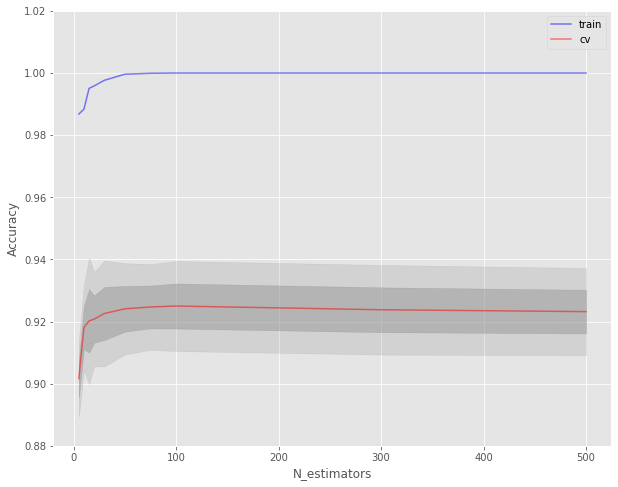

In [9]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

As you can see, when a certain number of trees is reached, our accuracy on the test goes to the asymptote, and you can decide for yourself how many trees are optimal for your task.
The figure also shows that we were able to achieve 100% accuracy on the training set, which tells us that our model was overfitting. To avoid overfitting, we must add regularization parameters to the model.

Let's start with the maximum depth parameter - `max_depth`. (fix the number of trees 100)

Best accuracy on CV is 92.50% with 30 max_depth


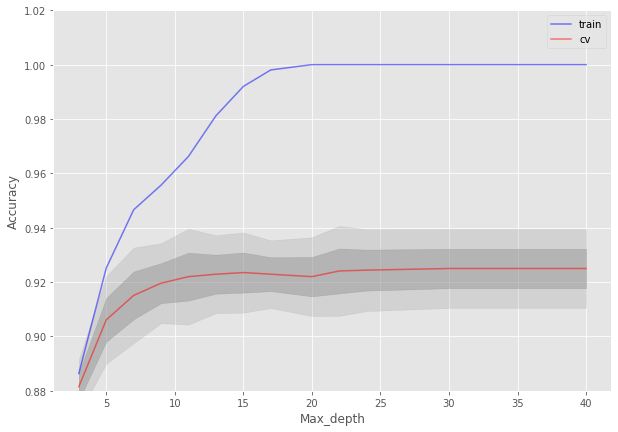

In [10]:
# Create lists to maintain accuracy on the training and test dataset
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24, 30, 40]

# Train on the training dataset
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр `max_depth` хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. Точность нашей модели немного возросла.

Еще важный параметр `min_samples_leaf`, он так же выполняет функцию регуляризатора.


In [11]:
# Create lists to maintain accuracy on the training and test dataset
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Train on the training dataset
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 1 min_samples_leaf


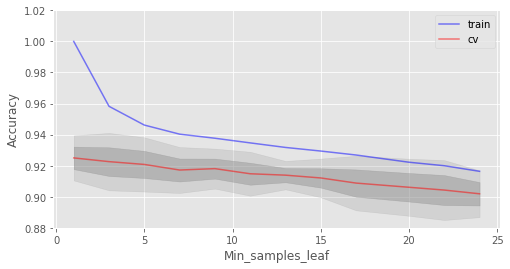

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

In this case, we do not win in accuracy on validation, but we can greatly reduce overfitting to 2% while maintaining an accuracy of about 92%.

Let's consider such parameter as `max_features`. For classification problems, $\large \sqrt{n}$ is used by default, where n is the number of features. Let's check whether it is optimal in our case to use 4 features or not.


Best accuracy on CV is 92.50% with 4 max_features


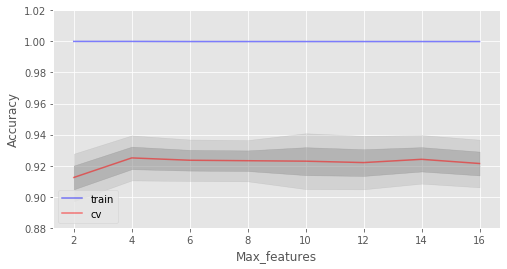

In [12]:
# Create lists to maintain accuracy on the training and test dataset
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Train on the training dataset
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

In our case, the optimal number of features is 4, with this value the best result is achieved.

We have considered how learning curves behave depending on the change in the main parameters. Let's now use `GridSearch` to find the optimal parameters for our example.


In [13]:
#timeit
# Let's initialize the parameters by which we want to do a full enumeration
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [14]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=3,
                        n_jobs=-1, oob_score=True, random_state=42),
 0.925596661128895)

The best accuracy we could achieve with parameter iteration is 92.559% at `'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3`.

**Useful sources:**
- Section 15 of the book “[Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)” by Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie
- more about the practical application of random forest and other composition algorithms in the official documentation [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html)
